# Portfolio risk estimation

In [1]:
from pandas_datareader.data import DataReader
from pandas_datareader.moex import MoexReader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats
from finance import plot_adjusted_price, plot_instruments_correlation, plot_mean_avg, correlation_matrix, getData, get_asset_returns
import datetime
from dateutil.relativedelta import relativedelta
from cvxopt import matrix, solvers
sns.set_style("whitegrid")
%matplotlib inline

/usr/local/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
symbols= """
HDV
DVY
QQQ
TQQQ
GAMR
ARKW
FINX
ICLN
QCLN
VCLT
LQD
TLT
TMF
ZROZ
GLTR
IBUY
VHT
ITA
VDC
VNQ
GNL
SBRA
APLE""".strip().split()

In [3]:
start_date = "2005-01-03"
end_date = "2020-11-01"
tickers_data =  getData(symbols, start_date=start_date, end_date=end_date)

HDV First not NA value date: 2011-03-31 00:00:00
DVY First not NA value date: 2005-01-03 00:00:00
QQQ First not NA value date: 2005-01-03 00:00:00
TQQQ First not NA value date: 2010-02-11 00:00:00
GAMR First not NA value date: 2016-03-10 00:00:00
ARKW First not NA value date: 2014-09-30 00:00:00
FINX First not NA value date: 2016-09-13 00:00:00
ICLN First not NA value date: 2008-06-25 00:00:00
QCLN First not NA value date: 2007-02-14 00:00:00
VCLT First not NA value date: 2009-11-23 00:00:00
LQD First not NA value date: 2005-01-03 00:00:00
TLT First not NA value date: 2005-01-03 00:00:00
TMF First not NA value date: 2009-04-16 00:00:00
ZROZ First not NA value date: 2009-11-04 00:00:00
GLTR First not NA value date: 2010-10-22 00:00:00
IBUY First not NA value date: 2016-04-20 00:00:00
VHT First not NA value date: 2005-01-03 00:00:00
ITA First not NA value date: 2006-05-05 00:00:00
VDC First not NA value date: 2005-01-03 00:00:00
VNQ First not NA value date: 2005-01-03 00:00:00
GNL First 

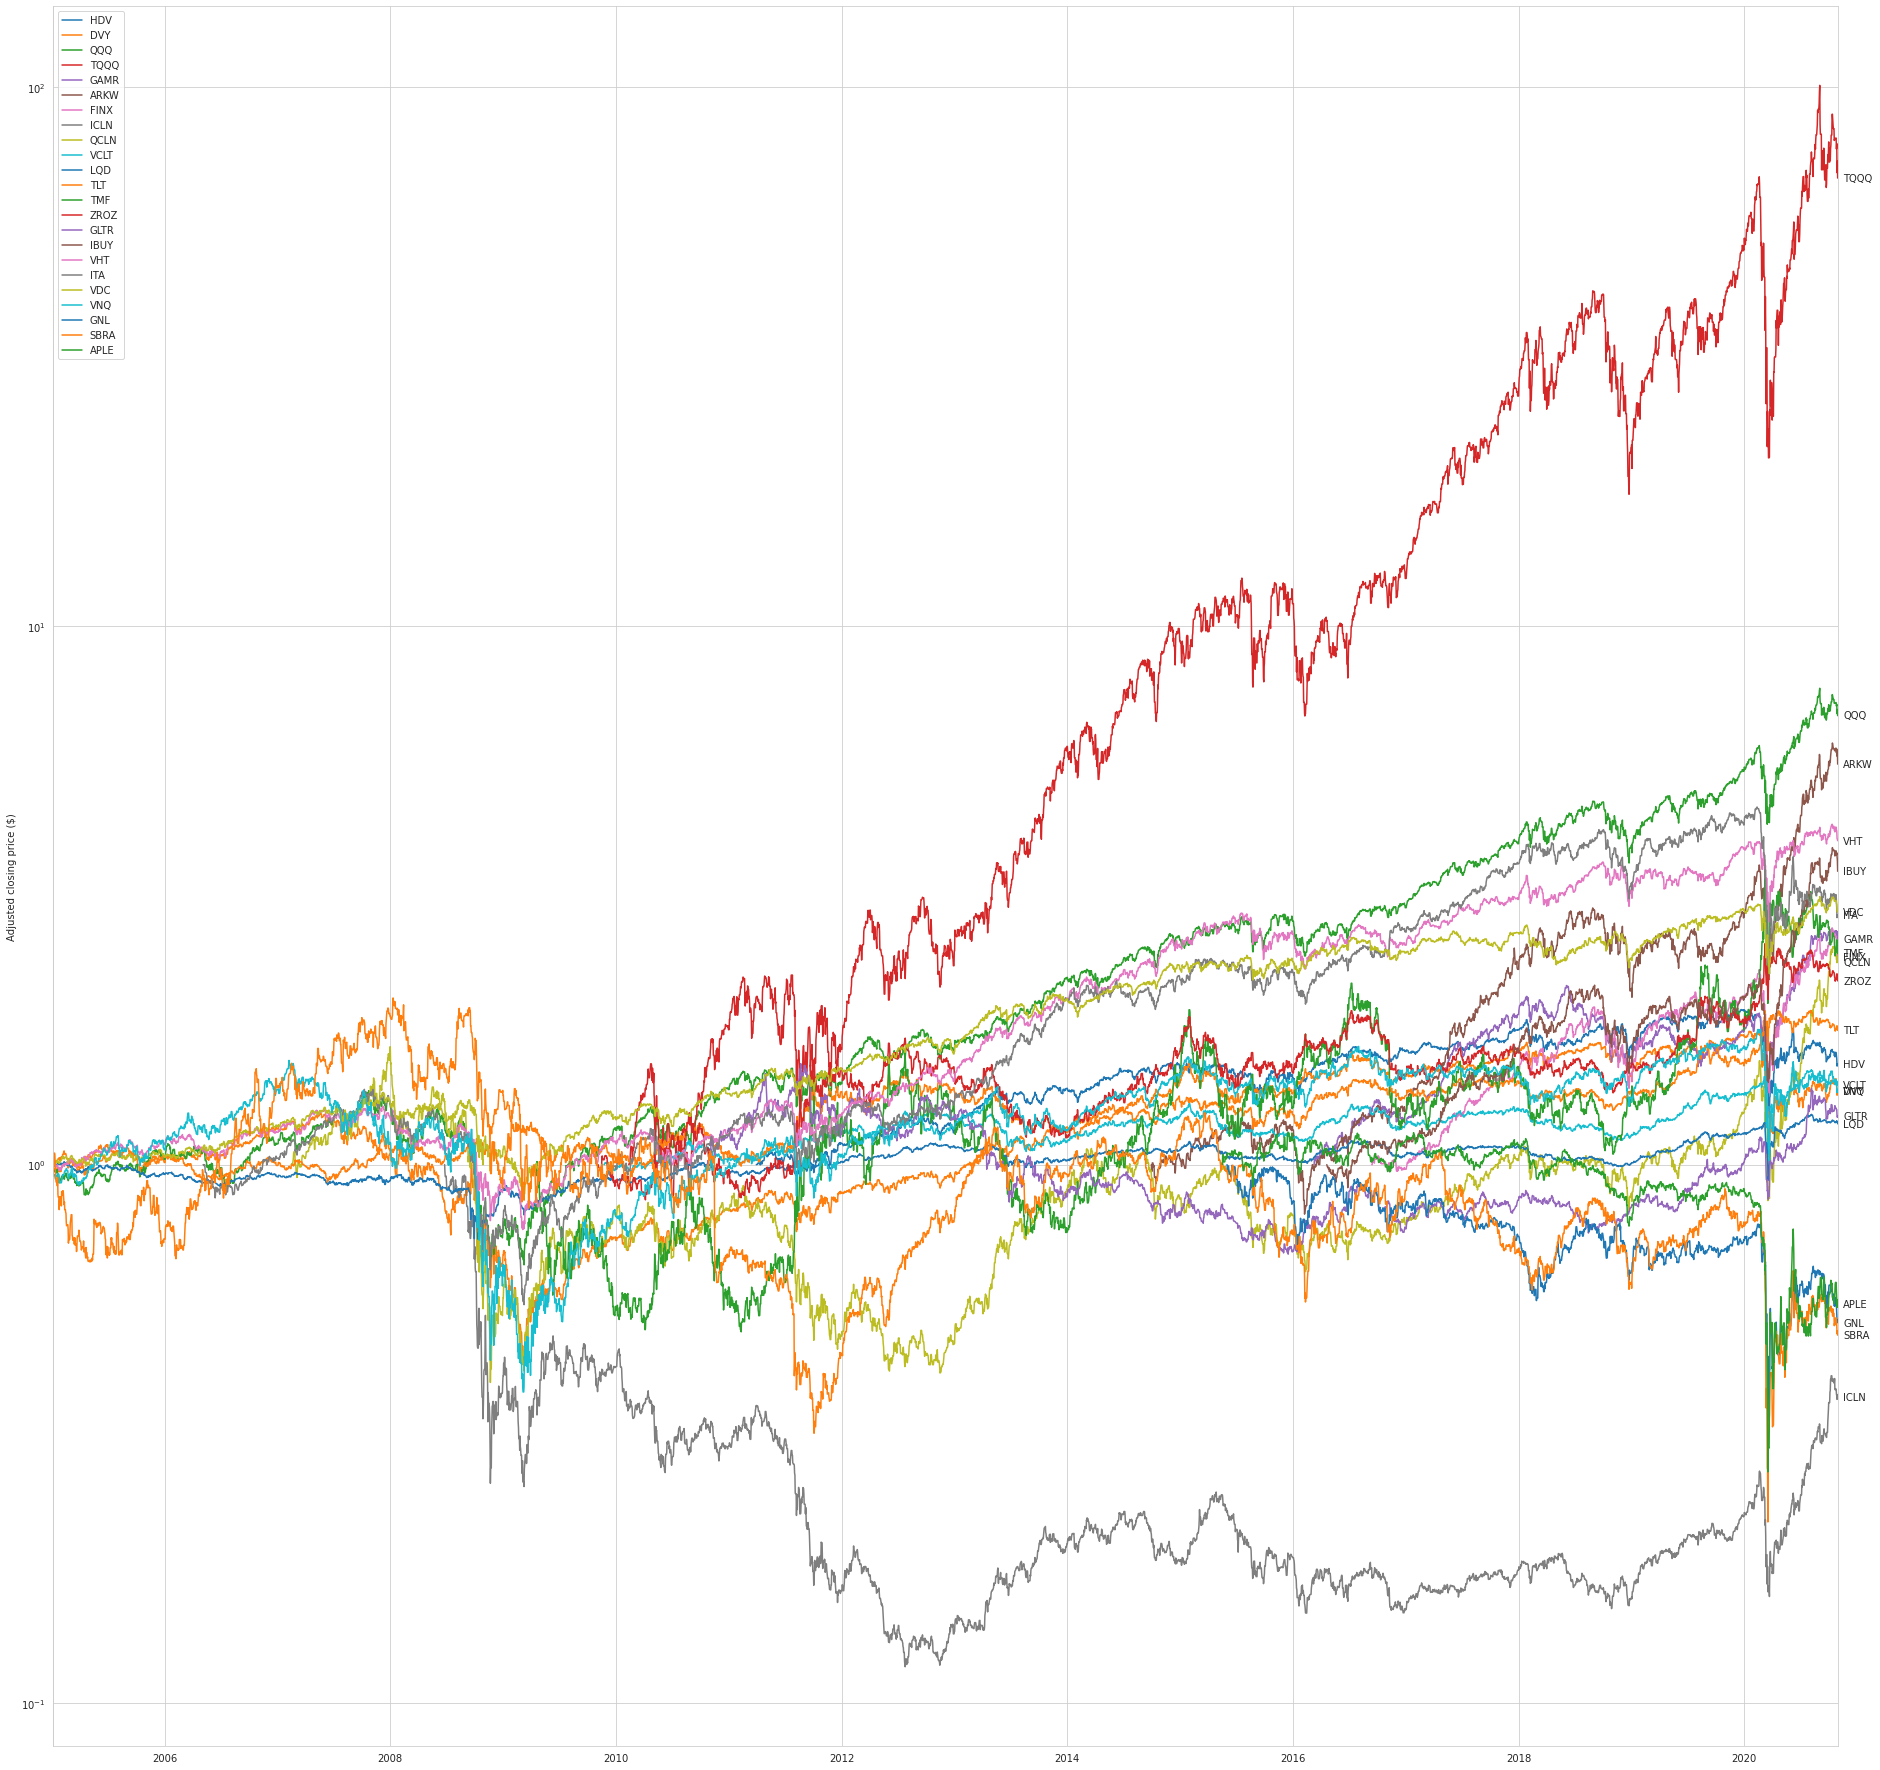

In [4]:
ax = plot_adjusted_price(tickers_data, (32,32))
ax.set_yscale("log")
#plot_adjusted_price(tickers_data.loc[:, (tickers_data / tickers_data.iloc[0, :]).iloc[-1] < 1], figsize=(16,20))

In [24]:
accet_return = get_asset_returns(tickers_data)

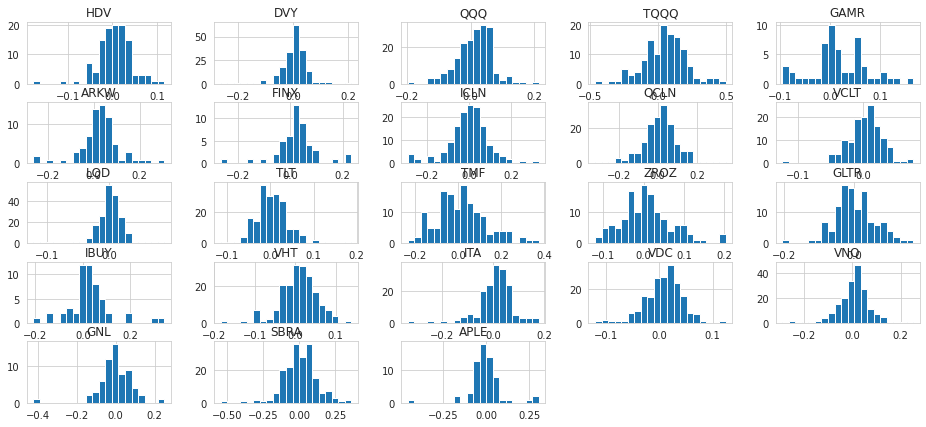

In [25]:
_ = accet_return.hist(bins=20, figsize=(16,7))

In [26]:
accet_loss = accet_return.copy()
accet_loss[accet_loss > 0] = 0

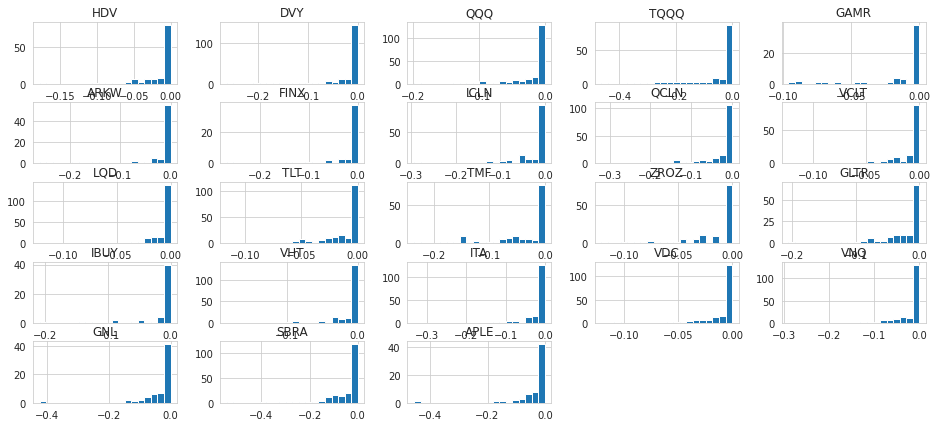

In [27]:
_ = accet_loss.hist(bins=20, figsize=(16,7))

In [28]:
avarage_return = accet_return.mean(axis=0)
std_return = accet_loss.std(axis=0)
corr_return = accet_loss.corr()

In [29]:
print(avarage_return)
print(std_return)
print(corr_return)

HDV     0.004782
DVY     0.003045
QQQ     0.011880
TQQQ    0.046316
GAMR    0.018885
ARKW    0.027844
FINX    0.022112
ICLN   -0.001346
QCLN    0.009709
VCLT    0.003064
LQD     0.001182
TLT     0.003927
TMF     0.015092
ZROZ    0.008102
GLTR    0.003276
IBUY    0.028853
VHT     0.008458
ITA     0.009309
VDC     0.006476
VNQ     0.004643
GNL    -0.003670
SBRA    0.004007
APLE   -0.004096
dtype: float64
HDV     0.024271
DVY     0.036609
QQQ     0.031698
TQQQ    0.084783
GAMR    0.026135
ARKW    0.051066
FINX    0.046587
ICLN    0.063379
QCLN    0.057018
VCLT    0.016186
LQD     0.013647
TLT     0.019165
TMF     0.054582
ZROZ    0.030017
GLTR    0.031774
IBUY    0.041848
VHT     0.026884
ITA     0.044287
VDC     0.020614
VNQ     0.046576
GNL     0.061151
SBRA    0.071856
APLE    0.065499
dtype: float64
           HDV       DVY       QQQ      TQQQ      GAMR      ARKW      FINX  \
HDV   1.000000  0.942781  0.693292  0.727895  0.509081  0.714237  0.854039   
DVY   0.942781  1.000000  0.6287

In [30]:
def portfolio_avarage_return(weights, avarage_return):
    return (weights * avarage_return).sum()

def portfolio_std_return(weights, std_return, corr_return):
    std_return = std_return.values[:, np.newaxis]
    weights = weights.values[:, np.newaxis]
    return (weights.dot(weights.T) * std_return.dot(std_return.T) * corr_return).sum().sum()

In [31]:
P = 2 * matrix(std_return.values * std_return.values[:, np.newaxis] * corr_return.values)
q = matrix(np.zeros_like(std_return.values))
n = len(std_return)
# G = matrix(np.zeros(shape=(n,1)), (1, len(std_return)))
# h = matrix([[0.0]])
G = -matrix(1.0 * np.diag([1]*len(corr_return)))
h = matrix(q)
A = matrix([
        [1.0] * len(std_return),
    ], 
    (len(std_return),1)
).trans()
b = matrix([1.0])

sol=solvers.qp(P, q, G, h, A, b, verbose=False)
best_weights = pd.Series(sol["x"], index=std_return.index)
best_weights[best_weights<1e-6] = 0
best_weights /= best_weights.sum()
print("\nPortfolio with lowest risk:")
print(best_weights)

     pcost       dcost       gap    pres   dres
 0:  9.2482e-04 -1.0008e+00  1e+00  1e-16  5e+00
 1:  9.2196e-04 -1.0799e-02  1e-02  1e-16  6e-02
 2:  7.4605e-04 -6.6427e-04  1e-03  2e-16  7e-03
 3:  4.6627e-04 -5.5408e-04  1e-03  2e-16  4e-03
 4:  2.5879e-04  5.4768e-05  2e-04  1e-16  4e-04
 5:  1.7398e-04  6.2036e-05  1e-04  2e-16  1e-18
 6:  1.4839e-04  1.2405e-04  2e-05  2e-16  9e-19
 7:  1.3950e-04  1.3702e-04  2e-06  2e-16  8e-19
 8:  1.3794e-04  1.3783e-04  1e-07  2e-16  9e-19
 9:  1.3787e-04  1.3786e-04  7e-09  2e-16  8e-19
Optimal solution found.

Portfolio with lowest risk:
HDV     0.000293
DVY     0.000000
QQQ     0.000011
TQQQ    0.000000
GAMR    0.003380
ARKW    0.000000
FINX    0.000000
ICLN    0.000000
QCLN    0.000000
VCLT    0.000001
LQD     0.505448
TLT     0.259702
TMF     0.000000
ZROZ    0.000000
GLTR    0.055364
IBUY    0.000000
VHT     0.013359
ITA     0.000000
VDC     0.162442
VNQ     0.000000
GNL     0.000000
SBRA    0.000000
APLE    0.000000
dtype: float64


# Same task for pinned return rate

In [32]:
rs = np.linspace(avarage_return.min()/1.2, avarage_return.max()*1.1, 100)
ws = {}

for r in rs:
    P = 2 * matrix(std_return.values * std_return.values[:, np.newaxis] * corr_return.values)
    q = matrix(np.zeros_like(std_return.values))
    G = -matrix(1.0 * np.diag([1]*len(corr_return)))
    h = matrix(q)
    n = len(std_return)
    A = matrix([
            [1.0] * len(std_return),
            list(avarage_return.values)
        ], 
        (len(std_return),2)
    ).trans()
    b = matrix([1.0, r])

    sol=solvers.qp(P, q, G, h, A, b, verbose=False)
    if sol["status"] == "unknown":
        continue
    weights = pd.Series(sol["x"], index=std_return.index)
    weights[weights<1e-6] = 0
    weights /= weights.sum()
    ws[r] = weights
ws = pd.DataFrame(ws).T
print(ws)

     pcost       dcost       gap    pres   dres
 0:  7.9075e-04 -1.0005e+00  3e+01  5e+00  5e+00
 1:  9.0713e-04 -8.3868e-01  3e+00  5e-01  5e-01
 2:  1.8471e-03 -8.0417e-02  8e-01  1e-01  1e-01
 3:  3.7089e-03 -9.4322e-02  2e-01  1e-02  1e-02
 4:  3.8602e-03 -1.8624e-02  2e-02  2e-04  2e-04
 5:  3.8374e-03  1.1192e-03  3e-03  2e-05  2e-05
 6:  3.4187e-03  7.1863e-04  3e-03  2e-16  5e-17
 7:  3.3562e-03  2.7517e-03  6e-04  2e-16  7e-17
 8:  3.2382e-03  2.6691e-03  6e-04  2e-16  7e-17
 9:  3.0988e-03  3.0553e-03  4e-05  1e-16  3e-17
10:  3.0759e-03  3.0754e-03  5e-07  8e-17  2e-17
11:  3.0756e-03  3.0756e-03  5e-09  2e-16  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  7.8721e-04 -1.0027e+00  3e+01  5e+00  5e+00
 1:  8.9715e-04 -8.4754e-01  3e+00  5e-01  5e-01
 2:  1.7699e-03 -1.2096e-01  7e-01  1e-01  1e-01
 3:  3.5451e-03 -1.2379e-01  2e-01  5e-03  5e-03
 4:  3.5801e-03 -1.7690e-03  5e-03  5e-05  5e-05
 5:  3.1854e-03  1.7686e-03  1e-03  6e-17  6e-1

     pcost       dcost       gap    pres   dres
 0:  9.1867e-04 -1.0012e+00  1e+00  2e-18  5e+00
 1:  9.1602e-04 -1.0835e-02  1e-02  2e-16  6e-02
 2:  7.5212e-04 -6.0042e-04  1e-03  1e-16  7e-03
 3:  4.2468e-04 -1.3982e-04  6e-04  5e-17  1e-03
 4:  2.8708e-04  1.7717e-04  1e-04  2e-16  6e-05
 5:  2.3336e-04  2.1305e-04  2e-05  2e-16  5e-06
 6:  2.1828e-04  2.1730e-04  1e-06  3e-16  8e-19
 7:  2.1771e-04  2.1770e-04  1e-08  9e-17  7e-19
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  9.3364e-04 -1.0012e+00  1e+00  2e-16  5e+00
 1:  9.3098e-04 -1.0869e-02  1e-02  3e-17  6e-02
 2:  7.6802e-04 -6.3140e-04  1e-03  1e-16  7e-03
 3:  3.9418e-04  1.1403e-05  4e-04  2e-16  2e-04
 4:  2.8558e-04  1.8495e-04  1e-04  2e-16  1e-18
 5:  2.4547e-04  2.2300e-04  2e-05  1e-16  1e-18
 6:  2.3125e-04  2.2912e-04  2e-06  2e-16  1e-18
 7:  2.3002e-04  2.2999e-04  2e-08  3e-16  9e-19
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  9.4938e-04 -1.0065e

 0:  1.6293e-03 -1.0984e+00  3e+01  5e+00  6e+00
 1:  1.8561e-03 -9.0617e-01  1e+00  9e-02  1e-01
 2:  2.0976e-03 -1.6618e-01  2e-01  4e-03  5e-03
 3:  2.1008e-03 -1.5812e-03  4e-03  9e-05  1e-04
 4:  1.7009e-03  5.4827e-04  1e-03  2e-05  2e-05
 5:  1.2976e-03  9.9223e-04  3e-04  2e-06  2e-06
 6:  1.0800e-03  1.0399e-03  4e-05  2e-16  4e-18
 7:  1.0542e-03  1.0536e-03  5e-07  1e-16  5e-18
 8:  1.0539e-03  1.0539e-03  5e-09  6e-17  2e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.6658e-03 -1.0993e+00  3e+01  5e+00  6e+00
 1:  1.9076e-03 -8.9994e-01  1e+00  1e-01  1e-01
 2:  2.1774e-03 -1.7963e-01  2e-01  5e-03  6e-03
 3:  2.1847e-03 -1.6257e-03  4e-03  9e-05  1e-04
 4:  1.8026e-03  5.8579e-04  1e-03  2e-05  3e-05
 5:  1.3718e-03  1.0481e-03  3e-04  1e-06  2e-06
 6:  1.1483e-03  1.1110e-03  4e-05  2e-16  4e-18
 7:  1.1238e-03  1.1234e-03  5e-07  1e-16  4e-18
 8:  1.1236e-03  1.1236e-03  5e-09  1e-16  4e-18
Optimal solution found.
     pcost       dcost

 3:  6.9235e-03 -1.2810e-02  2e-02  1e-14  2e-15
 4:  6.9229e-03  6.5557e-03  4e-04  1e-14  7e-16
 5:  6.8949e-03  6.7492e-03  1e-04  4e-15  2e-16
 6:  6.8380e-03  6.7087e-03  1e-04  3e-15  2e-16
 7:  6.7574e-03  6.7503e-03  7e-06  1e-16  2e-17
 8:  6.7546e-03  6.7545e-03  7e-08  1e-16  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  3.5606e-03 -9.9737e-01  4e+01  5e+00  7e+00
 1:  4.8371e-03 -4.0413e-01  2e+00  3e-01  4e-01
 2:  7.0187e-03 -9.4372e-03  1e-01  2e-02  2e-02
 3:  7.0928e-03 -3.0089e-03  1e-02  1e-04  2e-04
 4:  7.0933e-03  6.9286e-03  2e-04  1e-06  2e-06
 5:  7.0850e-03  7.0278e-03  6e-05  5e-07  6e-07
 6:  7.0647e-03  7.0108e-03  5e-05  4e-07  5e-07
 7:  7.0310e-03  7.0272e-03  4e-06  3e-09  4e-09
 8:  7.0296e-03  7.0295e-03  4e-08  4e-11  5e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  3.6265e-03 -9.9094e-01  4e+01  5e+00  7e+00
 1:  4.9456e-03 -3.8394e-01  2e+00  3e-01  4e-01
 2:  7.2056e-03  1.3145

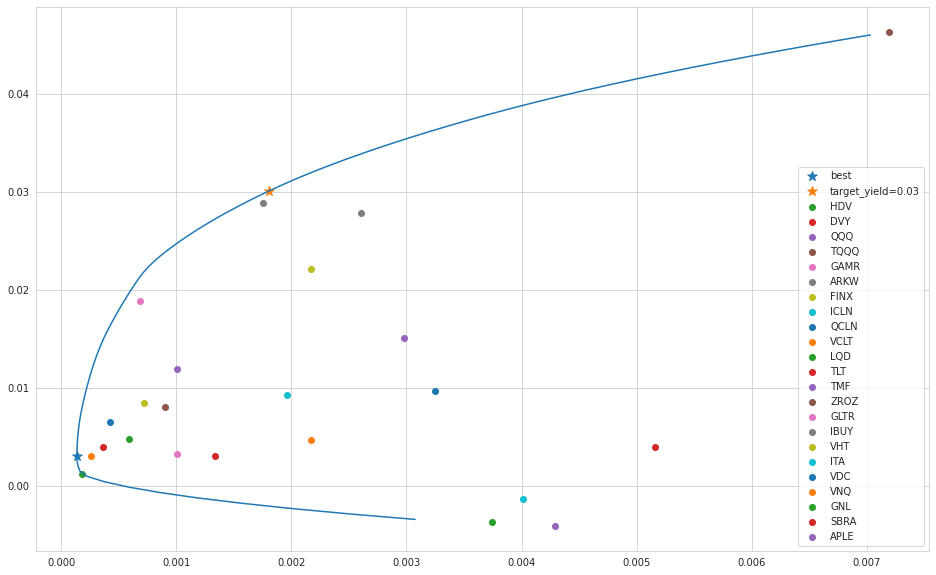

In [33]:
line_x = []
line_y = [] 
for _, weights in ws.iterrows():
    line_x.append(portfolio_std_return(weights, std_return, corr_return))
    line_y.append(portfolio_avarage_return(weights, avarage_return))
    
line_y = np.array(line_y)
line_x = np.array(line_x)

target_yield = 0.03 
target_yield_index = abs(line_y - 0.03).argmin()
target_yield_weights = ws.iloc[target_yield_index]

fig = plt.figure(figsize=(16,10))
ax = plt.subplot(111)
ax.plot(line_x, line_y)

ax.scatter(
    [portfolio_std_return(best_weights, std_return, corr_return)], 
    [portfolio_avarage_return(best_weights, avarage_return)],
    label="best",
    marker="*",
    s=100,
)

ax.scatter(
    [line_x[target_yield_index]], 
    [line_y[target_yield_index]], 
    label=f"target_yield={target_yield}",
    marker="*",
    s=100,
)

for asset_name in ws.columns:
    weights = pd.Series([0]*len(ws.columns), index=ws.columns)
    weights[asset_name] = 1
    ax.scatter(
        [portfolio_std_return(weights, std_return, corr_return)], 
        [portfolio_avarage_return(weights, avarage_return)],
        label=asset_name,
    )
    

ax.legend()

In [34]:
target_yield_weights

HDV     0.000000
DVY     0.000000
QQQ     0.000000
TQQQ    0.258612
GAMR    0.002799
ARKW    0.000000
FINX    0.000000
ICLN    0.000000
QCLN    0.000000
VCLT    0.000000
LQD     0.000000
TLT     0.000000
TMF     0.236838
ZROZ    0.000000
GLTR    0.000000
IBUY    0.501751
VHT     0.000000
ITA     0.000000
VDC     0.000000
VNQ     0.000000
GNL     0.000000
SBRA    0.000000
APLE    0.000000
Name: 0.030082113089362275, dtype: float64

In [35]:
tickers_data["lowest risk"] = (tickers_data * best_weights).sum(axis=1)
tickers_data["target yield"] = (tickers_data * target_yield_weights).sum(axis=1)

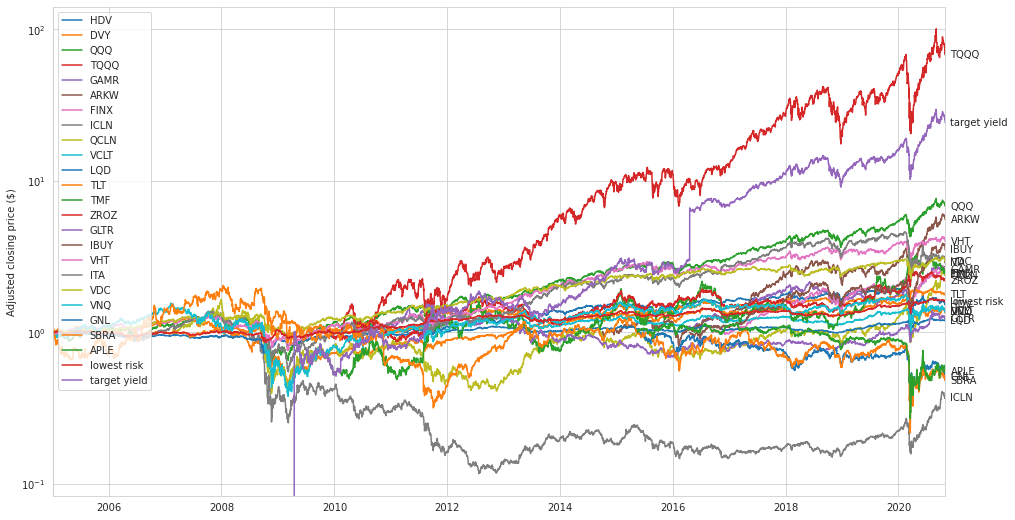

In [36]:
ax = plot_adjusted_price(tickers_data)
ax.set_yscale("log")

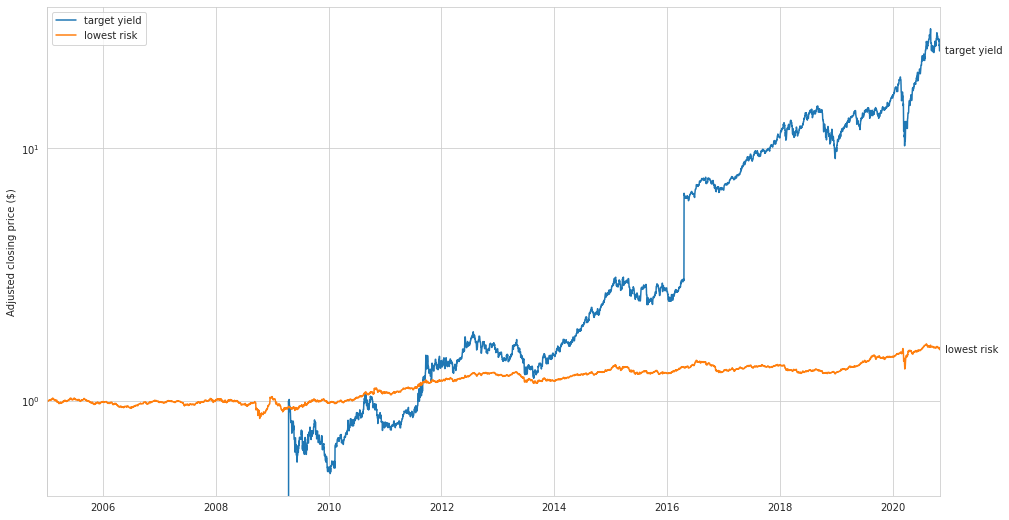

In [37]:
ax = plot_adjusted_price(tickers_data[["target yield", "lowest risk"]])
ax.set_yscale("log")

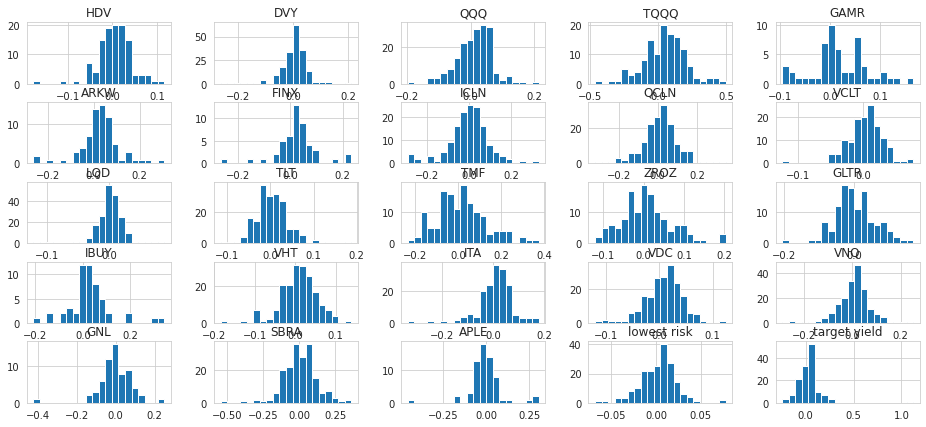

In [38]:
returns = get_accet_returns(tickers_data)
_ = returns.hist(bins=20, figsize=(16,7))